In [1]:
import pandas as pd
import sklearn
import numpy as np
import sys
sys.path.append('../utils/')
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN
from sklearn import metrics

from series_plot import plot_multi_series
from computation import *
from processing import *
from glob import glob

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def compute_fig_info(num_display):
    #split into several figures if number of plots exceed 9
    if num_display > 9:
        num_fig = int(num_display/9)
        last_fig_num = num_display%9
        num_display = num_fig*[9]
        if last_fig_num:
            num_display = num_fig*[9]+[last_fig_num]
    else: num_display = [num_display]
    return num_display


def plot_multi_series(series_list,index_list = [], title_names = [], x_series = []):
    plt.rcParams.update({'font.size': 16})
    
    if not len(index_list):
        num_display = len(series_list)
    else: num_display = len(index_list)
    display_list = compute_fig_info(num_display)
    if not len(x_series):
        x_series = np.linspace(0,len(series_list[0])-1,len(series_list[0]))
            
    for base,num_display in enumerate(display_list):
        plot_index = num_display*100+10
        
        # plotting properties 
        len_x = 12
        len_y = 2*num_display
        fig = plt.figure(figsize=(12,len_y))
        for i in range(num_display):
            plot_index+=1
            ax = fig.add_subplot(plot_index)
            idx = 9*base+i
            
            if index_list:
                idx = index_list[i]
                
            label = "series %d"%(idx)
            if len(title_names):
                label = title_names[idx]
            ax.plot(x_series,series_list[idx],label=label)
            ax.legend(loc=0)
            ax.set_xlabel('Sample Points')
#             ax.set_ylabel('Measuremnts')
    plt.show()
    return True
    

# Sampling the data

In [3]:
data_30_149 = pd.read_csv('../data/data_30_149.csv')

In [4]:
# remove units 
idx_bool = (data_30_149['[123]No.1 Soil Press (Bulkhead)'] != 'bar')
# idx_bool[0] =True
df = data_30_149[idx_bool]
# remove the last ring
df = df[df['[0][c]Ring No.'].astype('float64')<149]

In [5]:
# aggregate temperature data
keys = df.keys()
out_temp_keys = search_k(["circumference","outer","temp"],keys,not_s=[],thre=0.8)
inner_temp_keys = search_k(["circumference","inner","temp"],keys,not_s=[],thre=0.8)

df['mean temp outer circumference'] = (df[out_temp_keys].astype('float')).mean(axis = 1)
df['mean temp inner circumference'] = (df[inner_temp_keys].astype('float')).mean(axis = 1)

In [9]:
# aggregate pressure data
press_keys = search_k(["soil","press"],df.keys(),not_s=['Casings','limit',
                                                        'max','min','Back-Filling',
                                                        'Circumference','collapsing'],thre=0.8)
print (press_keys)
df['mean soil press (bulkhead)'] = (df[press_keys].astype('float')).mean(axis = 1)

['[123]No.1 Soil Press (Bulkhead)', '[124]No.2 Soil Press (Bulkhead)', '[125]No.3 Soil Press (Bulkhead)', '[126]No.4 Soil Press (Bulkhead)', '[127]No.5 Soil Press (Bulkhead)', '[128]No.6 Soil Press (Bulkhead)', '[129]No.7 Soil Press (Bulkhead)', '[130]No.8 Soil Press (Bulkhead)', '[131]No.9 Soil Press (Bulkhead)', '[132]No.10 Soil Press (Bulkhead)', '[133]No.11 Soil Press (Bulkhead)', '[134]No.12 Soil Press (Bulkhead)', 'mean soil press (bulkhead)']


In [10]:
keys_selected = ['mean temp outer circumference',
                 'mean soil press (bulkhead)',
                '[9]Total Thrust Force',
                '[2527][c]Thrust Speed Average',
                '[2495]Cutter Torque']

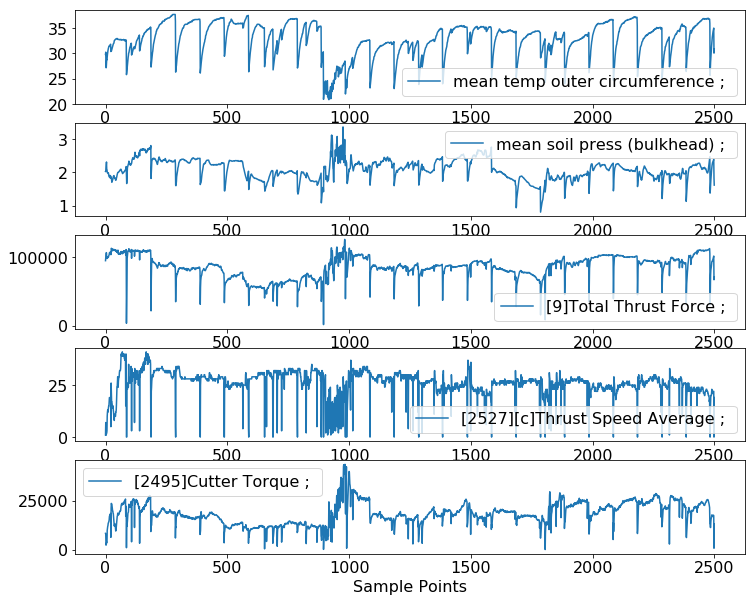

True

In [11]:
# get the data from dataframe 
series_data,sample_keys = get_series_data(df,keys_selected,unit=False)
series_data = series_data[:,:2500]
plot_multi_series(series_data,title_names=sample_keys)

In [12]:
# remove deep drop anomalies 
def remove_noise(series,window_size = 50,thre = 0.5):
    denoised_series = np.zeros(len(series))
    for i, d in enumerate(series):
        w = int(window_size/2)
        j = 2
        left_sample = series[max(i-w-j,0):i-j]
        right_sample = series[i+j:min(i+w+j,len(series))]
        mean_l,mean_r = np.mean(left_sample),np.mean(right_sample)
        
        r_l = (d-mean_l)/mean_l
        r_r = (d-mean_r)/mean_r
        denoised_series[i] = d
        
        if (d < mean_l) and (d<mean_r):
            if (abs(r_l)>thre) and (abs(r_r)>thre):
                denoised_series[i] = (mean_l+mean_r)/2
    return denoised_series.reshape(1,-1)
    

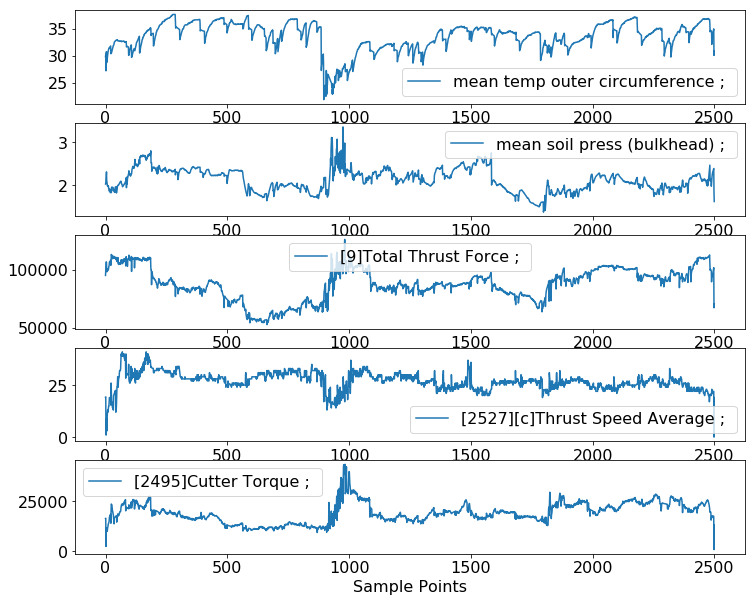

True

In [13]:
n,l = series_data.shape
clean_data_l = []
for i in range(n):
    clean_s = remove_noise(series_data[i,:],window_size=80,thre=0.05)
    clean_data_l.append(clean_s)


series_data = np.concatenate(clean_data_l,axis=0)
plot_multi_series(series_data,title_names=sample_keys)

In [27]:
def normalize_data(series_data):
    shape = series_data.shape
    norm_data = np.zeros(shape)
    
    for i in range(shape[0]):
        data = series_data[i,:]
        mean = data.mean()
        std = data.std()
        norm = (data-mean)/std
        norm_data[i,:] = norm
    return norm_data
    
    

In [28]:
norm_data = normalize_data(series_data)

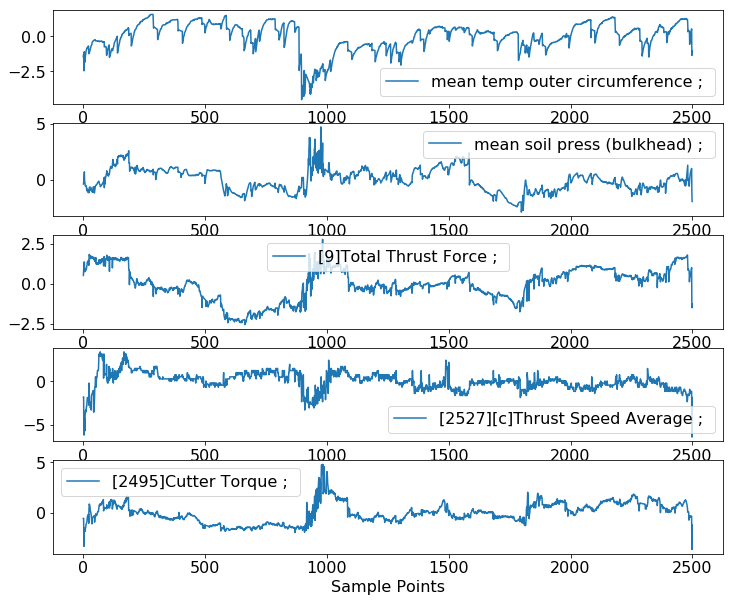

True

In [29]:
plot_multi_series(norm_data,title_names=sample_keys)

# Denoising

In [30]:
from scipy.signal import coherence,periodogram,welch
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.signal import find_peaks

In [31]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [32]:
fs = norm_data.shape[1]
n = norm_data.shape[0]
freq_content_list = []
for i in range(n):
    f, Pxx_den = periodogram(norm_data[i,:],fs = fs)
    freq_content_list.append(Pxx_den)  
    

In [33]:
def plot_multi_periodogram(f, freqlist, names,r=500):
    
    fig = plt.figure(figsize=(12,12))
    
    position_list = [511,512,513,514,515]
    for p, name,l in zip(freqlist,names,position_list):
        ax = fig.add_subplot(l)
        ax.semilogy(f[:r], p[:r],label=name+'periodogram')
        ax.set_ylim([1e-8, 1e1])
        ax.legend(loc=0)
        ax.set_ylabel('PSD [V**2/Hz]')
#         plt.title()
        
    plt.xlabel('frequency [Hz]')
    plt.show()
        

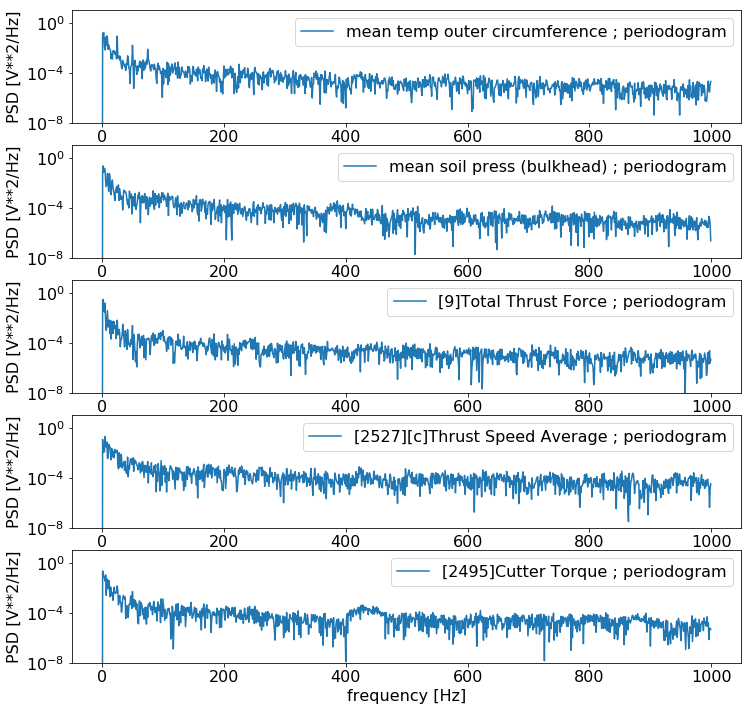

In [34]:
plot_multi_periodogram(f,freq_content_list,sample_keys,r=1000)

In [35]:
# find peaks
peak_list = []
height_thre = 1e-3
for p in freq_content_list:
    peaks, _ = find_peaks(p, height=height_thre)
    peak_list.append(peaks)

In [36]:
def find_common_freq(peaks,tolerence = 1):
    # get the longest freq list first
    p_base = []
    for p in peaks:
        if len(p)>len(p_base):
            p_base= p
    
    common_f = []
    for f in p_base:
        hit = 0
        for p in peaks:
            for c in p:
                pot_freq = c+np.linspace(-tolerence,tolerence,2*tolerence+1)
                if f in pot_freq:
                    hit+=1
                    continue
        if hit > len(peaks):
            common_f.append(f)
                    
    return common_f

In [37]:
common_f = find_common_freq(peak_list,2)
common_f

[1, 3, 5, 8, 11, 13, 16, 18, 21, 25, 28, 36, 48, 51, 53]

In [38]:
norm_data.shape[1]

2500

In [39]:
# lets generate high freq noise 
freq_pool = [116,
 345,
 348,
 463,
 465,
 577,
 579,
 581]
a =np.sqrt(1e-3) 
l = norm_data.shape[1]
t = np.linspace(1e-1,1,l)

tot_sig = np.zeros(l,dtype='complex128')
for i,f in enumerate(freq_pool):
    sig = a*((3/4)**i)*np.exp(1j*2*np.pi*f*t)
    tot_sig+=sig
noise = np.real(tot_sig)

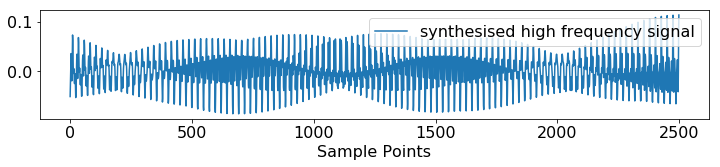

True

In [40]:
plot_multi_series(noise.reshape(1,-1),title_names=['synthesised high frequency signal'])

In [41]:
# do a sample
sample_p = freq_content_list[0]

In [42]:
def find_cut_off(sample_p, energy_thre=0.8):
    tot_energy = sample_p.sum()
    cum_energy = 0
    for i,p in enumerate(sample_p):
        cum_energy+=p
        ratio = cum_energy/tot_energy
        if ratio>energy_thre:
            break
    return i
    

In [43]:
cutoff = find_cut_off(sample_p)

In [44]:
y = butter_lowpass_filter(norm_data[0], cutoff, fs)

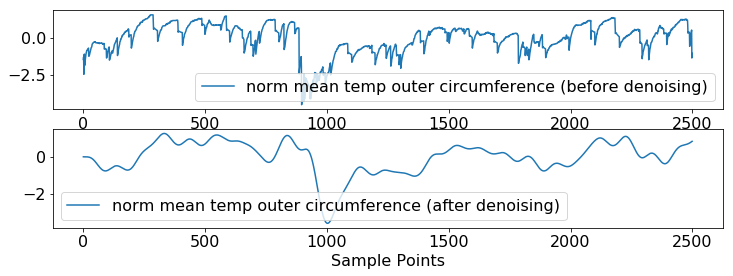

True

In [45]:
key_names = ['norm mean temp outer circumference (before denoising)',
            'norm mean temp outer circumference (after denoising)']
plot_multi_series([norm_data[0],y],title_names=key_names)

In [46]:
# remove wiggles
cutoff = find_cut_off(sample_p,0.8)
y2 = butter_lowpass_filter(norm_data[0], cutoff, fs)

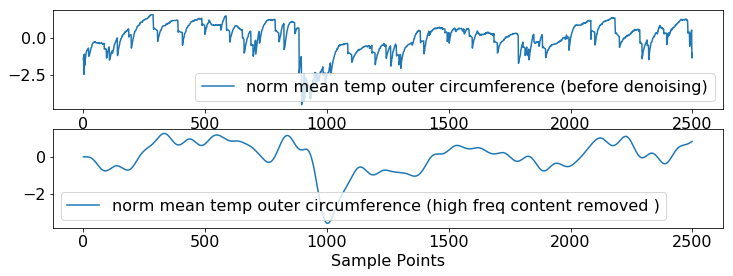

True

In [47]:
key_names = ['norm mean temp outer circumference (before denoising)',
            'norm mean temp outer circumference (high freq content removed )']
plot_multi_series([norm_data[0],y2],title_names=key_names)

In [48]:
 def get_clean_series_data(norm_data,freq_content_list,min_cutoff=50, energy_thre = 0.5):
    shape = norm_data.shape
    clean_data = np.zeros(shape)
    fs = shape[1]
    
    
    for i in range(shape[0]):
        data = norm_data[i,:]
        cutoff = max(min_cutoff,find_cut_off(freq_content_list[i],energy_thre))
        print (cutoff)
        low_data = butter_lowpass_filter(data, cutoff, fs)
        clean_data[i,:] = low_data

    return clean_data
    
    
    
        

In [49]:
series_data_low = get_clean_series_data(norm_data,freq_content_list,min_cutoff=100,energy_thre=0.95)

100
112
100
502
122


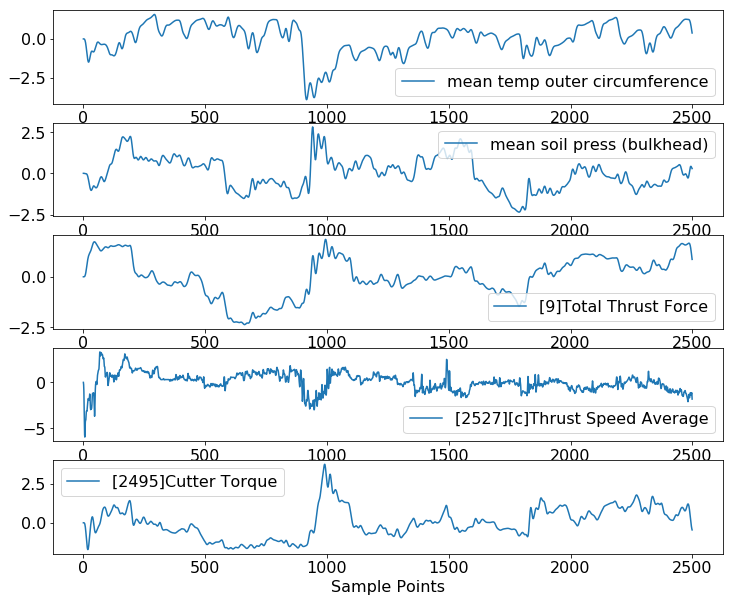

True

In [50]:
plot_multi_series(series_data_low,title_names=keys_selected)

In [51]:
ring_data, _ = get_series_data(data=df,keys=['[0][c]Ring No.'],unit=False)

# Feedline Data

In [52]:
poly_k = search_k(["Polymer","volume"],keys,not_s=[],thre=0.8)
print (poly_k)

['[679]No.3 GAP POLYMER FLOW CUMULATIVE VOLUME', '[752]No.4 GAP POLYMER FLOW CUMULATIVE VOLUME', '[753]No.5 GAP POLYMER FLOW CUMULATIVE VOLUME', '[765]No.6 GAP POLYMER FLOW CUMULATIVE VOLUME', '[2787][c]Polymer 1 Volume(Ring)', '[2788][c]Polymer 2 Volume(Ring)', '[2789][c]Polymer 3 Volume(Ring)', '[2790][c]Polymer 4 Volume(Ring)', '[2791][c]Polymer 5 Volume(Ring)', '[2792][c]Polymer 6 Volume(Ring)', '[2793][c]Polymer 7 Volume(Ring)', '[2794][c]Polymer 8 Volume(Ring)', '[2795][c]Polymer 9 Volume(Ring)', '[2796][c]Polymer 10 Volume(Ring)', '[2797][c]Polymer 11 Volume(Ring)', '[2798][c]Polymer 12 Volume(Ring)', '[2799][c]Polymer 13 Volume(Ring)', '[2800][c]Polymer 14 Volume(Ring)', '[2801][c]Polymer 15 Volume(Ring)', '[2802][c]Polymer 16 Volume(Ring)', '[2803][c]Polymer 17 Volume(Ring)', '[2804][c]Polymer 18 Volume(Ring)', '[2805][c]Polymer 19 Volume(Ring)', '[2806][c]Polymer 20 Volume(Ring)', '[2897]No.1 GAP POLYMER FLOW CUMULATIVE VOLUME', '[2898]No.2 GAP POLYMER FLOW CUMULATIVE VOLUME'

In [53]:
poly_keys = ['[2787][c]Polymer 1 Volume(Ring)', '[2788][c]Polymer 2 Volume(Ring)', '[2789][c]Polymer 3 Volume(Ring)', '[2790][c]Polymer 4 Volume(Ring)', '[2791][c]Polymer 5 Volume(Ring)', '[2792][c]Polymer 6 Volume(Ring)', '[2793][c]Polymer 7 Volume(Ring)', '[2794][c]Polymer 8 Volume(Ring)', '[2795][c]Polymer 9 Volume(Ring)', '[2796][c]Polymer 10 Volume(Ring)', '[2797][c]Polymer 11 Volume(Ring)', '[2798][c]Polymer 12 Volume(Ring)', '[2799][c]Polymer 13 Volume(Ring)', '[2800][c]Polymer 14 Volume(Ring)', '[2801][c]Polymer 15 Volume(Ring)', '[2802][c]Polymer 16 Volume(Ring)', '[2803][c]Polymer 17 Volume(Ring)', '[2804][c]Polymer 18 Volume(Ring)', '[2805][c]Polymer 19 Volume(Ring)', '[2806][c]Polymer 20 Volume(Ring)']
df['mean polymer volume'] = (df[poly_keys].astype('float')).mean(axis = 1)

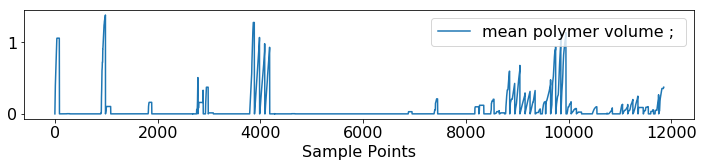

True

In [54]:
ring_data, names = get_series_data(data=df,keys=['mean polymer volume'],unit=False)
plot_multi_series(ring_data,title_names=names)

In [55]:
feedline_keys = ['mean polymer volume',
                 '[2829][c]Foam Volume(Ring)',
#                 '[2970][c]Total Keep Vol',
                '[2974][c]No.1 High Press Water Volume',
                '[2973][c]Total Refill Flow Vol']

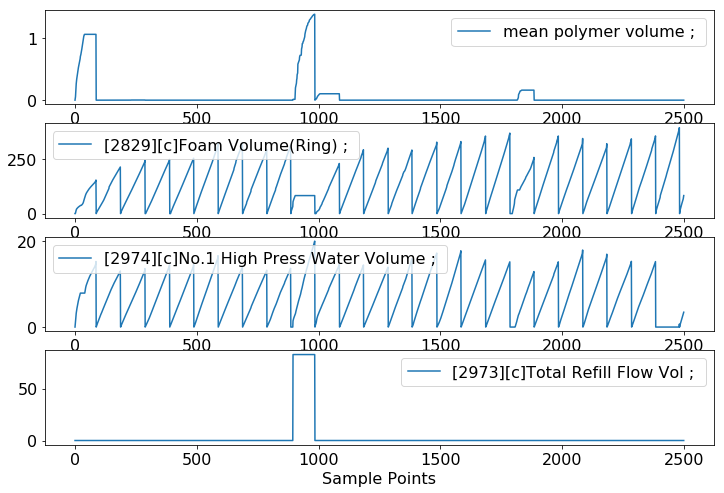

True

In [56]:
feedline_data, names = get_series_data(data=df,keys=feedline_keys,unit=False)
feedline_data = feedline_data[:,:2500]
plot_multi_series(feedline_data,title_names=names)

In [57]:
# final stage of refill flow is out of scale, deal with it
thre = 200
for i,ele in enumerate(feedline_data[-1,:]):
    if ele>thre:
        feedline_data[-1,i] = thre

In [58]:
def normalize_data_feedline(series_data):
    shape = series_data.shape
    norm_data = np.zeros(shape)
    
    for i in range(shape[0]):
        data = series_data[i,:]
        mean = data.mean()
        std = data.std()
        norm = (data-mean)/std
        norm_data[i,:] = norm-norm.min()
    return norm_data
    
    

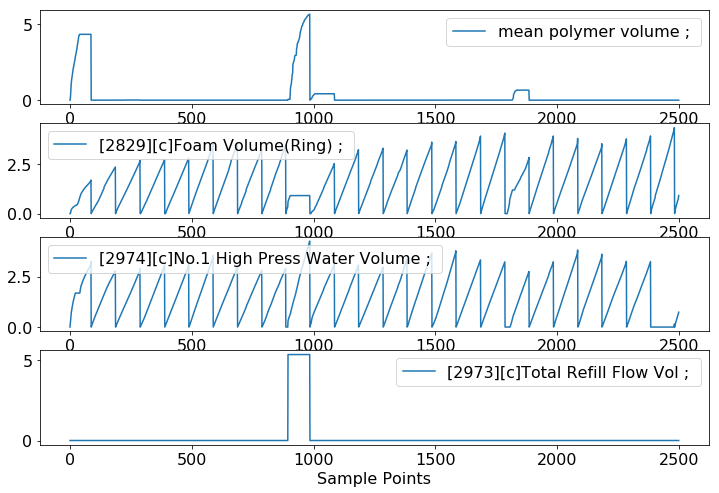

True

In [59]:
# normalize the data first 
feedline_norm = normalize_data_feedline(feedline_data)
plot_multi_series(feedline_norm,title_names=names)

In [60]:
# add them all to form the total feedline data 
feedline_data_tot = np.zeros(feedline_norm.shape[1])
for i in range(feedline_norm.shape[0]):
    feedline_data_tot+=feedline_norm[i]

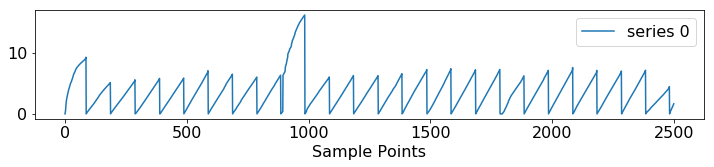

True

In [61]:
plot_multi_series(feedline_data_tot.reshape(1,-1))

In [62]:
stroke_k = search_k(["stroke",'net'],keys,not_s=[],thre=0.8)
print (stroke_k)

['[1][c]Net Stroke', '[2590][c]Net Stroke Diff L-R', '[2684][c]Robotec Net Stroke']


In [63]:
stroke_data, names = get_series_data(data=df,keys=stroke_k[:1],unit=False)
stroke_data = stroke_data[:,:2500]

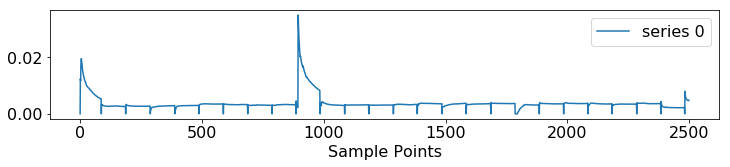

True

In [64]:
feedline_data_rate_tot = feedline_data_tot/(stroke_data+1) 
plot_multi_series(feedline_data_rate_tot)

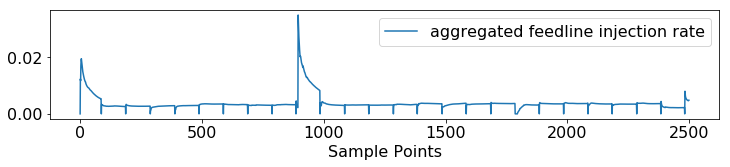

True

In [65]:
# final stage is a bit off chart, rescale it 
thre = 0.05
for i,ele in enumerate(feedline_data_rate_tot[0]):
    if ele>thre:
        feedline_data_rate_tot[0,i] = thre
plot_multi_series(feedline_data_rate_tot,title_names=['aggregated feedline injection rate'])

In [66]:
# filter it

fs = feedline_data_rate_tot.shape[1]
n = feedline_data_rate_tot.shape[0]
freq_content_list = []
for i in range(n):
    f, Pxx_den = periodogram(feedline_data_rate_tot[i,:],fs = fs)
    freq_content_list.append(Pxx_den)  
    

feedline_data_tot_filtered = get_clean_series_data(feedline_data_rate_tot,freq_content_list,
                                                   min_cutoff=200,energy_thre=0.9)

200


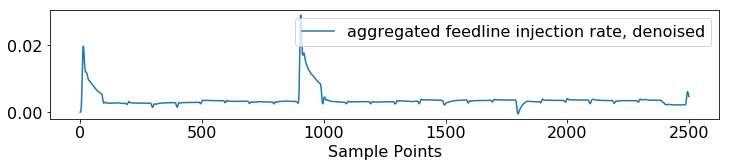

True

In [67]:
plot_multi_series(feedline_data_tot_filtered,title_names=['aggregated feedline injection rate, denoised'])

# discharge line data

In [68]:
discharge_k = search_k(["belt","scale","ring"],keys,not_s=[],thre=0.8)
print (discharge_k)

['[2993][c]Belt Scale Front Weight(Ring)', '[2997][c]Belt Scale Rear Weight(Ring)', '[3014][c]TBM Belt conveyor Earth Volume Scale Front Weight(Ring) by PLS', '[3018][c]TBM Belt conveyor Earth Volume Scale Rear Weight(Ring) by PLS']


In [69]:
discharge_data,names = get_series_data(df,discharge_k[:-1],unit=False)
discharge_data = discharge_data[:,:2500]
discharge_rate = discharge_data/(stroke_data+1) 

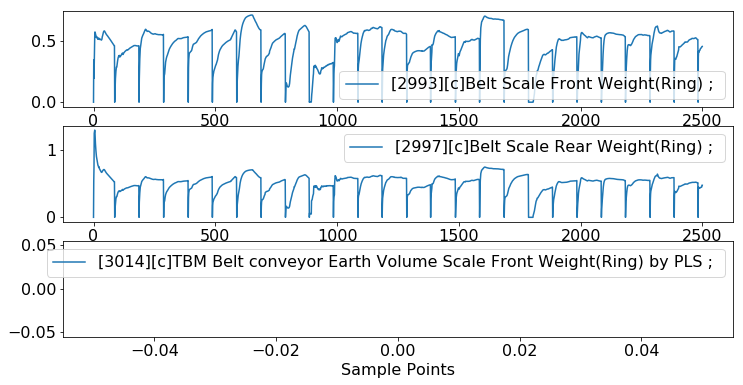

True

In [70]:
plot_multi_series(discharge_rate[:,:],title_names=names)

# Final data analysis

In [71]:
series_data_low.shape

(5, 2500)

In [72]:
series_data_final = np.concatenate((series_data_low,
                                   feedline_data_tot_filtered.reshape(1,-1)),
                                  axis = 0)
keys_selected.append("feedline input rate (tot)")

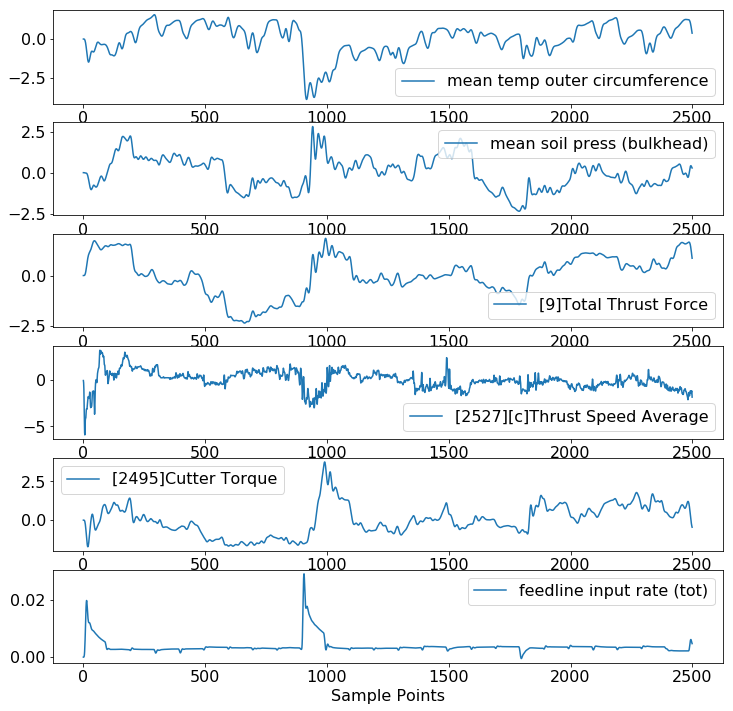

True

In [73]:
plot_multi_series(series_data_final,title_names=keys_selected)

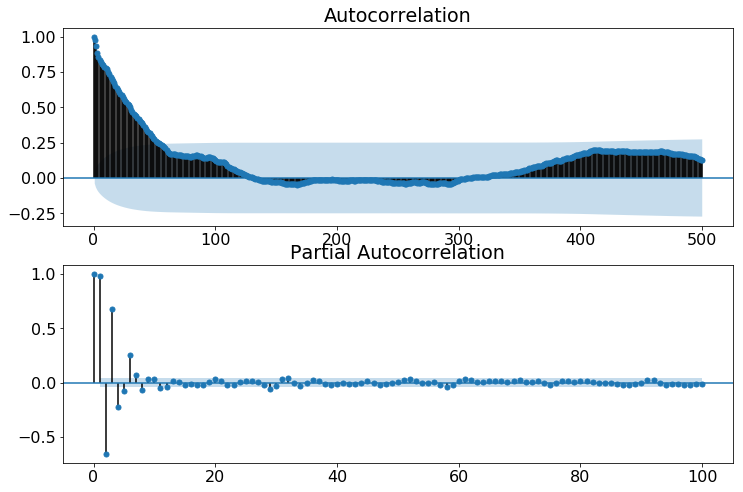

In [74]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series_data_final[-3,:], lags=500, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series_data_final[-3,:], lags=100, ax=ax2)

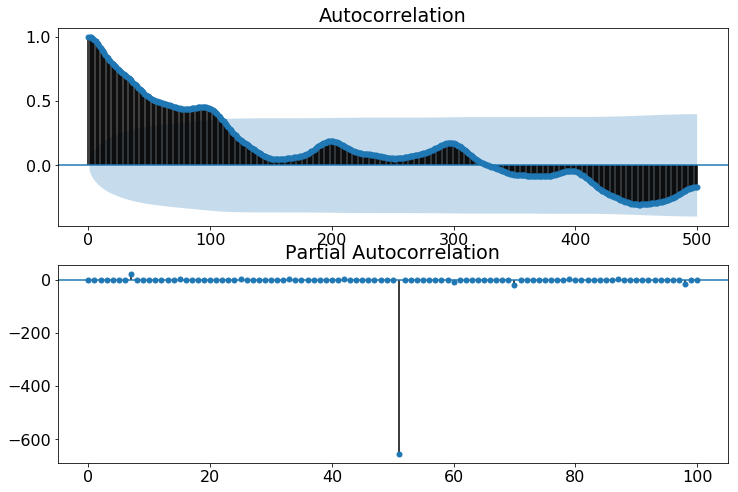

In [75]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series_data_final[0,:], lags=500, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series_data_final[0,:], lags=100, ax=ax2)

In [76]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):   
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )

In [77]:
test_stationarity(norm_data[2,:])

Results of Dickey-Fuller Test:
Test Statistic                   -2.295481
p-value                           0.173430
#Lags Used                       21.000000
Number of Observations Used    2478.000000
Critical Value (1%)              -3.432992
Critical Value (5%)              -2.862707
Critical Value (10%)             -2.567391
dtype: float64


In [78]:
# # remove seasonal effect for temperature 
temp_season_remove = series_data_final[0,:]-np.roll(series_data_final[0,:],100)
test_stationarity(temp_season_remove)

Results of Dickey-Fuller Test:
Test Statistic                   -4.349878
p-value                           0.000364
#Lags Used                       12.000000
Number of Observations Used    2487.000000
Critical Value (1%)              -3.432982
Critical Value (5%)              -2.862703
Critical Value (10%)             -2.567389
dtype: float64


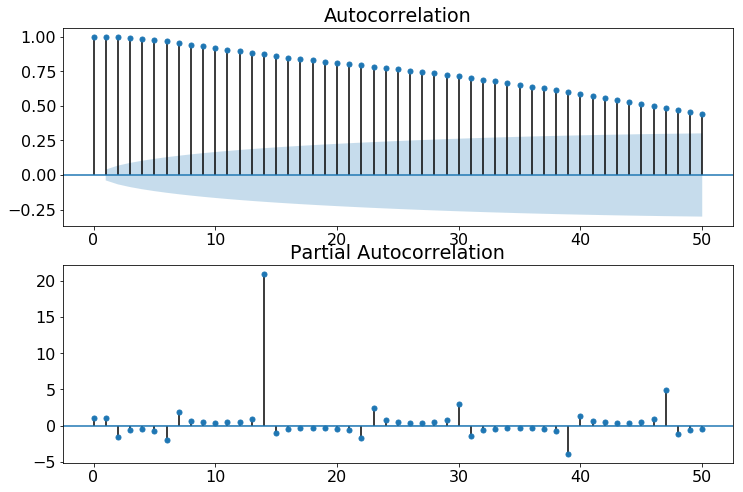

In [79]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_season_remove, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_season_remove, lags=50, ax=ax2)

Results of Dickey-Fuller Test:
Test Statistic                -9.472623e+00
p-value                        4.067780e-16
#Lags Used                     1.100000e+01
Number of Observations Used    2.488000e+03
Critical Value (1%)           -3.432981e+00
Critical Value (5%)           -2.862702e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


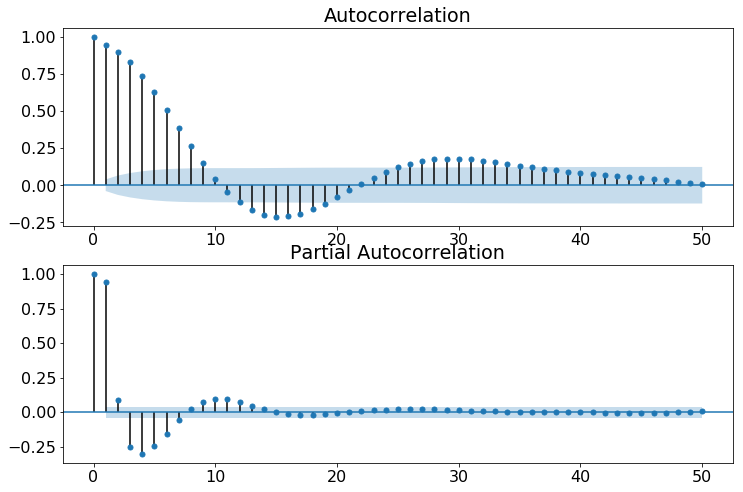

In [80]:
temp_season_remove_first_d = temp_season_remove-np.roll(temp_season_remove,1)
test_stationarity(temp_season_remove_first_d)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_season_remove_first_d, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_season_remove_first_d, lags=50, ax=ax2)

In [105]:
arma_mod32 = sm.tsa.ARMA(temp_season_remove_first_d[:2000], (3,3)).fit(disp=False)
print(arma_mod32.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2000
Model:                     ARMA(3, 3)   Log Likelihood                5734.865
Method:                       css-mle   S.D. of innovations              0.014
Date:                Wed, 24 Apr 2019   AIC                         -11453.729
Time:                        20:28:19   BIC                         -11408.922
Sample:                             0   HQIC                        -11437.277
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.005     -0.532      0.595      -0.013       0.007
ar.L1.y        2.7676      0.041     66.917      0.000       2.686       2.849
ar.L2.y       -2.6108      0.077    -33.761      0.0

In [65]:
resid = arma_mod32.resid

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Residual plot for the fitted ARMA model')

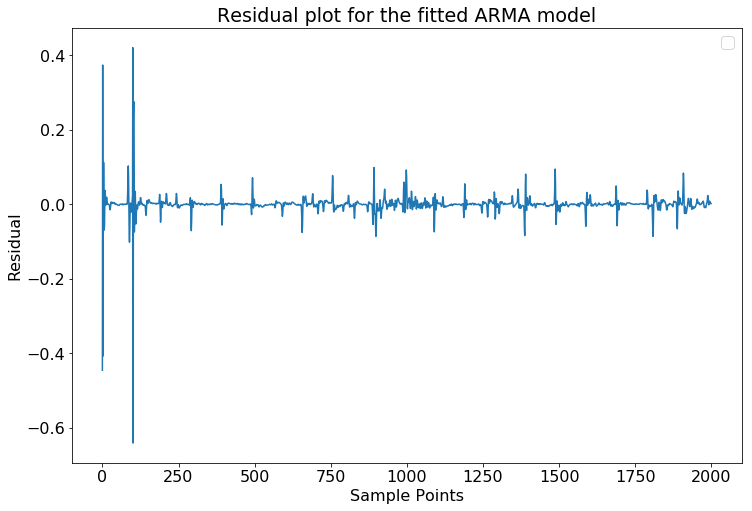

In [66]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = plt.plot(resid)
plt.legend(loc=0)
plt.xlabel('Sample Points')
plt.ylabel('Residual')
plt.title('Residual plot for the fitted ARMA model')

Text(0.5, 1.0, 'qq plot for the fitted ARMA model')

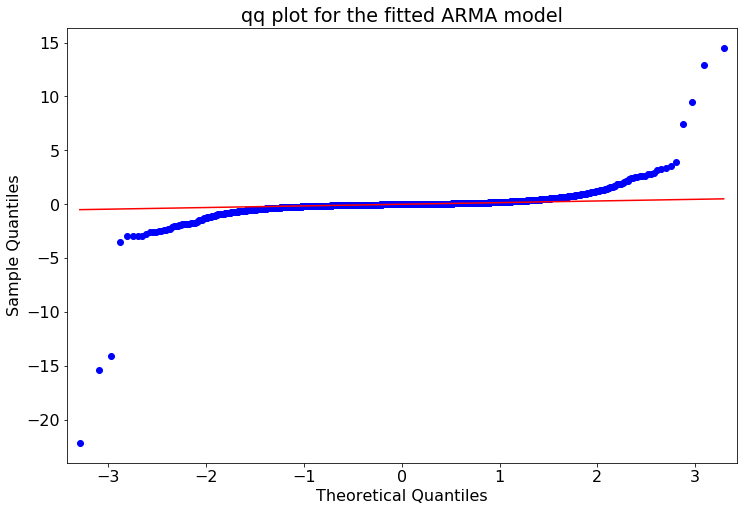

In [67]:
from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.title('qq plot for the fitted ARMA model')

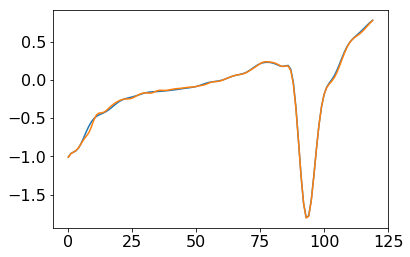

In [68]:
start,end = 1900,2020
predict_data = arma_mod32.predict(0,len(temp_season_remove)-1,dynamic=False)

origial_data = predict_data+np.roll(temp_season_remove,1)
season_recover_data = origial_data+np.roll(series_data_final[0,:],100)
#+np.roll(series_data_final[0,:],100)
plt.plot(series_data_final[0,:][start:end])
plt.plot(season_recover_data[start:end])
plt.show()


In [69]:
pred = []
for i in range(2000,2500):
    if not len(pred):
        previous = origial_data[i-1]
    else:
        previous = pred[-1]
    pred_val = previous+predict_data[i]
    pred.append(pred_val)
pred = pred +np.roll(season_recover_data,100)[2000:2500]
season_recover_data[2000:2500] = pred

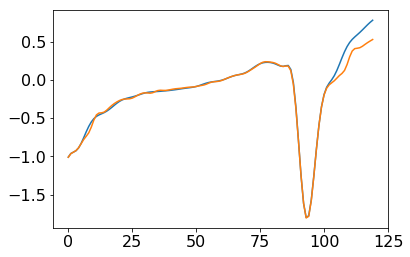

In [70]:
plt.plot(series_data_final[0,:][start:end])
plt.plot(season_recover_data[start:end])

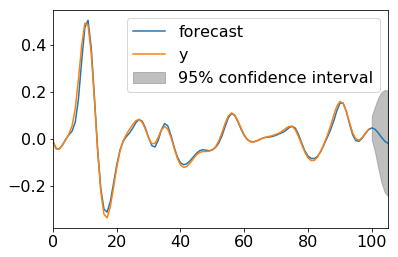

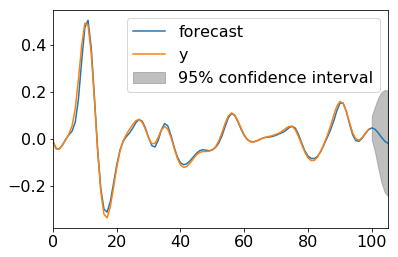

In [71]:
arma_mod32.plot_predict(2000-100, 2000+5)


In [72]:
# correlation analysis
n,l = series_data_final.shape
corr_list = []
for i in range(n):
    s1= series_data_final[i]
    for j in range(i+1,n):
        s2 = series_data_final[j]
        cor = compute_corr(s1,s2)
        corr_list.append((keys_selected[i],
                        keys_selected[j],
                        cor))
        

In [12]:
# lag analysis
import statsmodels.api as sm
import matplotlib.pyplot as plt
key_simp = ['temp','press','thrust-force','speed','torque','feedline']
def plot_ccf(idx1,idx2,r = -1):
    data1 = series_data_final[idx1][:r]
    data2 = series_data_final[idx2][:r]
    ccf1 = sm.tsa.stattools.ccf(data1,data2,unbiased=False)
    plt.plot(ccf1[:200])
    plt.xlabel('Lag')
    plt.ylabel('CCF')
    plt.title("CCF of "+key_simp[idx1] +" VS." + key_simp[idx2])
    
def plot_certain_series(idx1,idx2,r = -1):
    speed_feedline = np.concatenate((series_data_final[idx1][:r].reshape(1,-1)
                                     ,series_data_final[idx2][:r].reshape(1,-1)),axis=0)
    plot_multi_series(speed_feedline,title_names=[keys_selected[idx1],keys_selected[idx2]])

In [13]:

plot_certain_series(0,-1,10000)

NameError: name 'series_data_final' is not defined

In [25]:
sample_keys

['mean temp outer circumference ; ',
 'mean soil press (bulkhead) ; ',
 '[9]Total Thrust Force ; ',
 '[2527][c]Thrust Speed Average ; ',
 '[2495]Cutter Torque ; ']

/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: 

Text(0, 0.5, 'CCF')

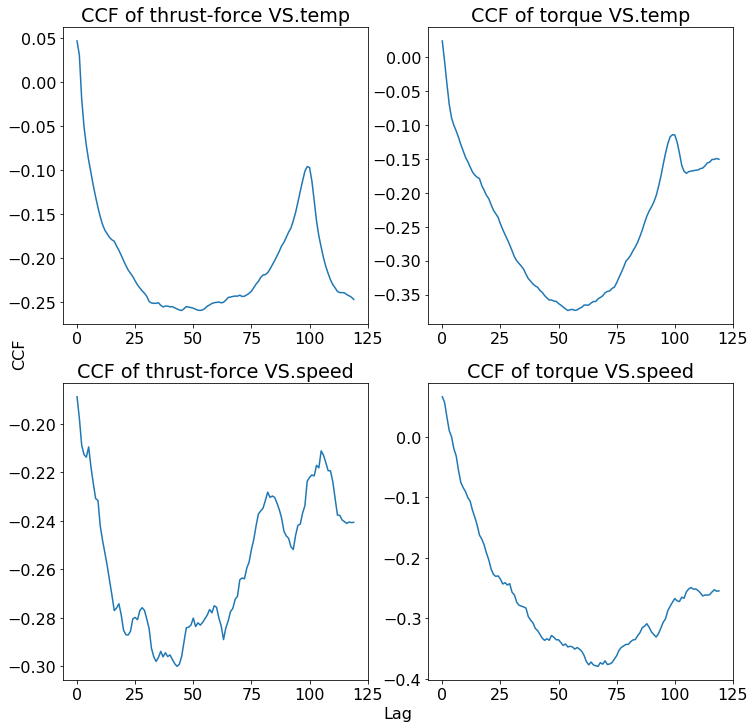

In [28]:
fig = plt.figure(figsize=(12,12))   
position_list = [221,222,223,224]

idx_tup_list = [(2,0),(4,0),(2,3),(4,3)]
count = 0
ax0 = fig.add_subplot(111)  
for idx_tup,l in zip(idx_tup_list,position_list):
    count+=1
    idx1,idx2=idx_tup
    data1 = norm_data[idx1]
    data2 = norm_data[idx2]
    ccf1 = sm.tsa.stattools.ccf(data1,data2,unbiased=False)
    
    ax = fig.add_subplot(l)
    title_name = "CCF of "+key_simp[idx1] +" VS." + key_simp[idx2]
    z = 120
    if count<3:
        z = 120
    ax.plot(ccf1[:z])
    ax.set_title(title_name)

# 
ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')
ax0.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')      
ax0.set_xlabel('Lag')
ax0.set_ylabel('CCF')

# plot_ccf(-1,0,10000)
# plot_ccf(-3,0,10000)
# plot_certain_series(0,-3,10000)

/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/rj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: 

Text(0, 0.5, 'CCF')

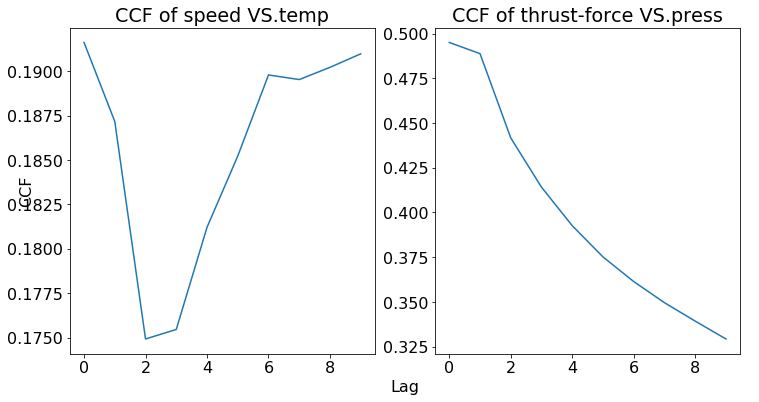

In [23]:
fig = plt.figure(figsize=(12,6))   
position_list = [121,122]
idx_tup_list = [(3,0),(2,1)]
count = 0
ax0 = fig.add_subplot(111)  
for idx_tup,l in zip(idx_tup_list,position_list):
    count+=1
    idx1,idx2=idx_tup
    data1 = series_data[idx1]
    data2 = series_data[idx2]
    ccf1 = sm.tsa.stattools.ccf(data1,data2,unbiased=False)
    
    ax = fig.add_subplot(l)
    title_name = "CCF of "+key_simp[idx1] +" VS." + key_simp[idx2]
    z = 10
    if count<3:
        z = 10
    ax.plot(ccf1[:z])
    ax.set_title(title_name)

# 
ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')
ax0.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')      
ax0.set_xlabel('Lag')
ax0.set_ylabel('CCF')

# plot_ccf(-1,0,10000)
# plot_ccf(-3,0,10000)
# plot_certain_series(0,-3,10000)

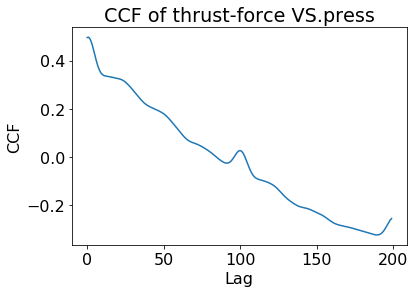

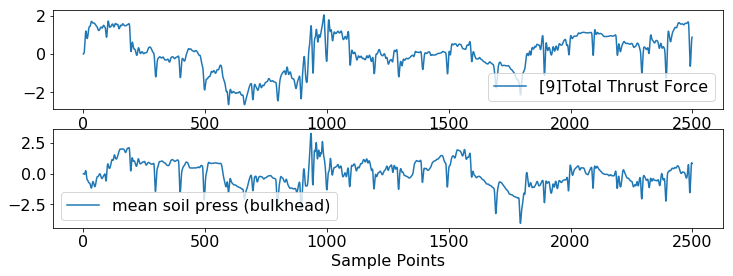

In [77]:
idx1,idx2 = 2,1
r = 5000
plot_ccf(idx1,idx2,r)
plot_certain_series(idx1,idx2,r)

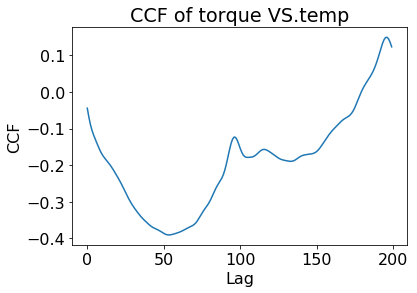

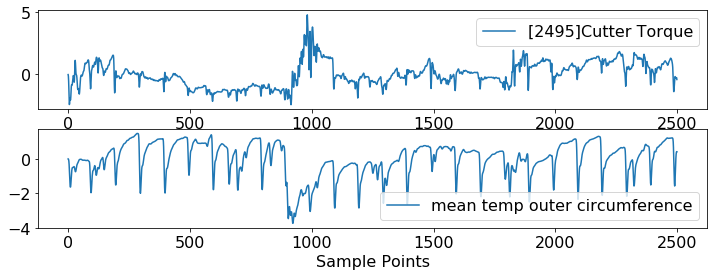

In [78]:
idx1,idx2 = -2,0
r = 10000
plot_ccf(idx1,idx2,r)
plot_certain_series(idx1,idx2,r)

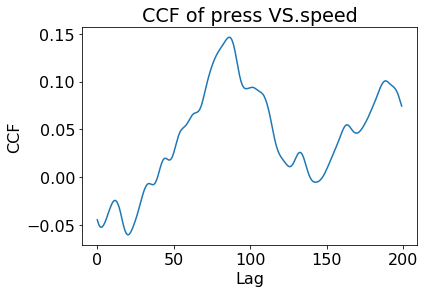

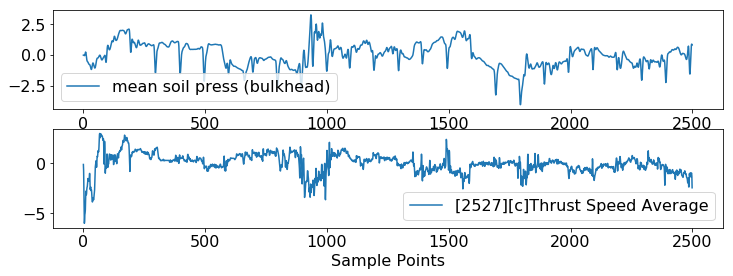

In [79]:
idx1,idx2 = 1,3
r = 10000
plot_ccf(idx1,idx2,r)
plot_certain_series(idx1,idx2,r)

# Analyze ring 138-146 data

In [80]:
upper = df['[0][c]Ring No.'].astype('float64')<146
lower = df['[0][c]Ring No.'].astype('float64')>137

In [81]:
start = 999999
end = 0

for i, j in enumerate(zip(list(lower),list(upper))):
    s,e = j
    if (s ==True) and i <start:
        start = i
    if (e ==True) and i >end:
        end = i
print (start,end)
        

10749 11549


In [82]:
data_139_145 = series_data_final[:,start:end]

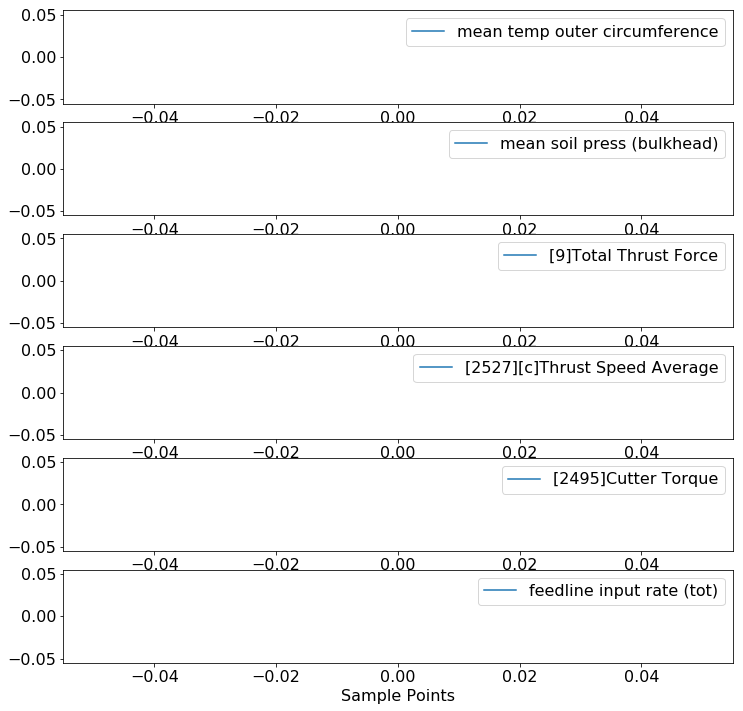

True

In [83]:
plot_multi_series(data_139_145,title_names=keys_selected)

# analyze the thrust speed

In [84]:
speed_data = series_data[-2,:]
speed_diff = speed_data-np.roll(speed_data,1)

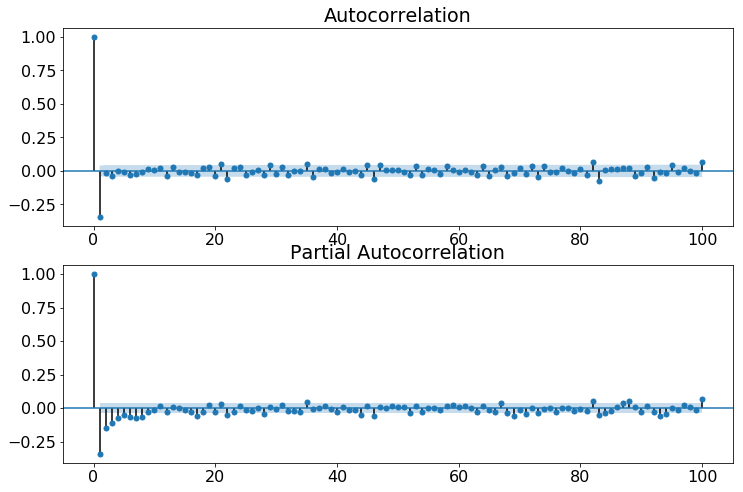

In [85]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(speed_diff, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(speed_diff, lags=100, ax=ax2)

In [39]:
 def compute_polynomial_coefficients( x1, x2, f1, f2, df1, df2):
        """
        Method to compute the coefficients of a smoothing polynomial.
        Parameters
        ----------
        x1: float
            point on the x-axis at which the smoothing polynomial begins
        x2: float
            point on the x-axis at which the smoothing polynomial ens
        f1: float
            function evaluated at x1
        f2: float
            function evaluated at x2
        df1: float
            derivative evaluated at x1
        df2: float
            derivative evaluated at x2
        Returns
        -------
        A tuple with the smoothing polynomail coefficients starting with the cubic term.
        """
        # A = np.matrix([[x1**3.0, x1**2.0, x1, 1.0],
        #                [x2**3.0, x2**2.0, x2, 1.0],
        #                [3.0*x1**2.0, 2.0*x1, 1.0, 0.0],
        #                [3.0*x2**2.0, 2.0*x2, 1.0, 0.0]])
        # rhs = np.matrix([[f1],
        #                  [f2],
        #                  [df1],
        #                  [df2]])
        # x = np.linalg.solve(A,rhs)
        a = (2*(f1-f2) - (x1-x2)*(df2+df1))/(x2**3-x1**3+3*x1*x2*(x1-x2))
        b = (df1 - df2 + 3*(x2**2-x1**2)*a)/(2*(x1-x2))
        c = df2 - 3*x2**2*a - 2*x2*b
        d = f2 - x2**3*a - x2**2*b - x2*c
        # print 'a: ',a,float(x[0][0])
        # print 'b: ',b,float(x[1][0])
        # print 'c: ',c,float(x[2][0])
        # print 'd: ',d,float(x[3][0])
        # assert (abs(a-float(x[0][0])) <= 1e-2)
        # assert (abs(b-float(x[1][0])) <= 1e-3)
        # assert (abs(c-float(x[2][0])) <= 1e-5)
        # assert (abs(d-float(x[3][0])) <= 1e-6)
        # return (float(x[0][0]), float(x[1][0]), float(x[2][0]), float(x[3][0]))
        return a, b, c, d

In [40]:
compute_polynomial_coefficients( 1, 2, 3, 4, 5, 6)

(9.0, -40.0, 58.0, -24.0)